In [87]:
#import the working library
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
%matplotlib inline

In [25]:
#read tickers as specified in excel in addition to market 
all_tickers = pd.read_excel('mapping.xlsx')[['Ticker', 'Market']]
#list all tickers
all_tickers

,Ticker,Market
0,ARGT,Emerging
1,EWA,Developed
2,EWO,Developed
3,EWK,Developed
4,EWZ,Emerging
5,EWC,Developed
6,ECH,Emerging
7,MCHI,Emerging
8,ICOL,Emerging
9,EDEN,Developed


In [26]:
factor_description = pd.read_excel('factor description.xlsx', index_col='Short Name')
factor_description

,Name,Category
Short Name,,
mom_21,Short-term Absolute Momentum (21-trading day),Technical
mom_63,Medium-term Absolute Momentum (63-trading day),Technical
mom_252,Long-term Absolute Momentum (252-trading day),Technical
mr_21,Percentage over Short-term Moving Average (21-...,Technical
mr_63,Percentage over Medium-term Moving Average (63...,Technical
mr_252,Percentage over Long-term Moving Average (252-...,Technical
div_yield,Dividend Yield,Fundamental
pb,Price/Book Ratio,Fundamental
pe,Price/Earning Ratio,Fundamental


In [27]:
#specified factor and date
factor_to_analyze = 'mom_252'
description_factor_to_analyze = factor_description.loc[factor_to_analyze, 'Name']
print(description_factor_to_analyze)
start_date_train = '2015-01-01'
end_date_train = '2018-12-31'
start_date_test = '2019-01-01'
end_date_test = '2019-12-31'

In [40]:
#list all etf in datafrome
all_etf_combined_df = pd.DataFrame()

#going throw each etf forward return 
for file in os.listdir('forward return'):
    fr_df = pd.read_csv('forward return/'+file, index_col='Date')
    fr_df['Ticker'] = file[:-4]
    try:
        factor_df = pd.read_csv('factor data/'+factor_to_analyze+'/'+file[:-4]+'.csv', index_col='Date')
        combined_df = fr_df.join(factor_df).rename({factor_to_analyze: 'Factor'}, axis=1)
        combined_df['Factor'] = combined_df['Factor'].fillna(method='ffill')
        all_etf_combined_df = pd.concat([all_etf_combined_df, combined_df.dropna().reset_index()], axis=0, ignore_index=True)
    except:
        continue

all_etf_combined_df = all_etf_combined_df.join(all_tickers.set_index('Ticker'), on='Ticker').dropna()
all_etf_combined_df = all_etf_combined_df.sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])[start_date_train:end_date_train]
all_etf_combined_df['Winsorized Factor'] = np.nan
all_etf_combined_df['Normalized Winsorized Factor'] = np.nan
all_etf_combined_df['Normalized Winsorized Factor Quartile'] = -1

#combine all factors
for date in all_etf_combined_df.index.get_level_values(0).unique():
    for market in ['Developed', 'Emerging']:
        n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]
        all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['Factor'], limits=1/n_etf*2)
        all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'])
        all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor Quartile'] = pd.qcut(all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'], 5, labels=False)

In [47]:
all_etf_combined_df.loc['2015-01-02'].drop('f_rtn', axis=1)

Factor  Winsorized Factor  Normalized Winsorized Factor  \
Market    Ticker                                                              
Developed EDEN    0.073955           0.073955                      1.420832   
          EFNL   -0.017174          -0.017174                      0.243530   
          EIRL    0.000940           0.000940                      0.477543   
          EIS    -0.010012          -0.010012                      0.336056   
          ENOR   -0.209467          -0.187163                     -1.952583   
          ENZL    0.120773           0.073955                      1.420832   
          EWA    -0.041690          -0.041690                     -0.073196   
          EWC     0.012166           0.012166                      0.622577   
          EWD    -0.066113          -0.066113                     -0.388722   
          EWG    -0.095167          -0.095167                     -0.764082   
          EWH     0.042654           0.042654                      1.016451   
          EWI    -0.092121          -0.092121                     -0.724724   
          EWJ    -0.044848          -0.044848                     -0.114003   
          EWK     0.022792           0.022792                      0.759851   
          EWL     0.001427           0.001427                      0.483834   
          EWN    -0.047022          -0.047022                     -0.142086   
          EWO    -0.187163          -0.187163                     -1.952583   
          EWP    -0.025632          -0.025632                      0.134248   
          EWQ    -0.090452          -0.090452                     -0.703168   
          EWS     0.034550           0.034550                      0.911752   
          EWU    -0.073225          -0.073225                     -0.480608   
          PGAL   -0.317573          -0.187163                     -1.952583   
          VOO     0.145898           0.073955                      1.420832   
Emerging  ARGT   -0.032030          -0.032030                     -0.127239   
          ECH    -0.131426          -0.131426                     -0.680454   
          EGPT    0.146184           0.146184                      0.864668   
          EIDO    0.223431           0.223431                      1.294606   
          EPHE    0.240255           0.240255                      1.388250   
          EPOL   -0.161100          -0.161100                     -0.845616   
          EPU    -0.040653          -0.040653                     -0.175231   
          ERUS   -0.423777          -0.283437                     -1.526516   
          EWM    -0.112845          -0.112845                     -0.577036   
          EWT     0.084619           0.084619                      0.522006   
          EWW    -0.113601          -0.113601                     -0.581247   
          EWY    -0.101815          -0.101815                     -0.515646   
          EWZ    -0.154494          -0.154494                     -0.808845   
          EZA     0.047769           0.047769                      0.316911   
          GREK   -0.390364          -0.283437                     -1.526516   
          ICOL   -0.283437          -0.283437                     -1.526516   
          INDA    0.296496           0.240255                      1.388250   
          MCHI    0.101650           0.101650                      0.616801   
          THD     0.255224           0.240255                      1.388250   
          TUR     0.190464           0.190464                      1.111121   

                  Normalized Winsorized Factor Quartile  
Market    Ticker                                         
Developed EDEN                                        4  
          EFNL                                        2  
          EIRL                                        3  
          EIS                                         2  
          ENOR                                        0  
          ENZL                                        4  


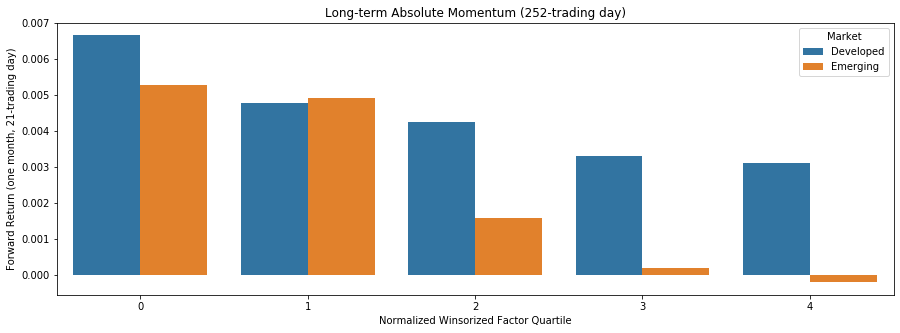

In [88]:
#factor quantile study by developed and emerging market
summary_df = all_etf_combined_df.reset_index().groupby(['Market', 'Normalized Winsorized Factor Quartile']).mean()[['f_rtn']]
plt.figure(figsize=(15, 5))
sns.barplot(x='Normalized Winsorized Factor Quartile', 
            y='Forward Return (one month, 21-trading day)', 
            hue='Market', 
            data=summary_df.reset_index().rename(factor_description['Name'].to_dict(), axis=1))
plt.title(description_factor_to_analyze)
plt.savefig('factor analysis results/'+factor_to_analyze+'.png')
plt.show()
summary_df.rename(factor_description['Name'].to_dict(), axis=1).T.to_excel('factor analysis results/'+factor_to_analyze+'.xlsx')

In [77]:
#reorganize table by market
all_etf_combined_df.groupby(['Market'])

f_rtn    factor  winsorized factor  \
Date       Market    Ticker                                          
2015-01-02 Developed EDEN    0.015891  0.073955           0.073955   
                     EFNL    0.040772 -0.017174          -0.017174   
                     EIRL    0.029430  0.000940           0.000940   
                     EIS     0.007761 -0.010012          -0.010012   
                     ENOR    0.075848 -0.209467          -0.187163   
...                               ...       ...                ...   
2018-12-31 Emerging  PAK     0.120978 -0.300630          -0.300630   
                     QAT     0.052043  0.211525          -0.021842   
                     THD     0.097688 -0.075031          -0.075031   
                     TUR     0.176247 -0.413340          -0.309426   
                     UAE     0.038578 -0.143227          -0.143227   

                             normalized winsorized factor  \
Date       Market    Ticker                                 
2015-01-02 Developed EDEN                        1.420832   
                     EFNL                        0.243530   
                     EIRL                        0.477543   
                     EIS                         0.336056   
                     ENOR                       -1.952583   
...                                                   ...   
2018-12-31 Emerging  PAK                        -1.606755   
                     QAT                         1.376551   
                     THD                         0.807373   
                     TUR                        -1.700883   
                     UAE                         0.077608   

                             normalized winsorized factor quartile  
Date       Market    Ticker                                         
2015-01-02 Developed EDEN                                      NaN  
                     EFNL                                      NaN  
                     EIRL                                      NaN  
                     EIS                                       NaN  
                     ENOR                                      NaN  
...                                                            ...  
2018-12-31 Emerging  PAK                                       NaN  
                     QAT                                       NaN  
                     THD                                       NaN  
                     TUR                                       NaN  
                     UAE                                       NaN  

[46489 rows x 5 columns]

In [55]:
#specified start date in developed market
date = '2015-01-02'
market = 'Developed'

In [57]:
#combine all etf by market
n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]

In [61]:
#listed the specified date and market
all_etf_combined_df.loc[date].loc[market]['winsorized factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['factor'], limits=1/n_etf*2)
all_etf_combined_df.loc[date].loc[market]['normalized winsorized factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['winsorized factor'])

In [62]:
#show the result
all_etf_combined_df

f_rtn    factor  winsorized factor  \
Date       Market    Ticker                                          
2015-01-02 Developed EDEN    0.015891  0.073955           0.073955   
                     EFNL    0.040772 -0.017174          -0.017174   
                     EIRL    0.029430  0.000940           0.000940   
                     EIS     0.007761 -0.010012          -0.010012   
                     ENOR    0.075848 -0.209467          -0.187163   
...                               ...       ...                ...   
2018-12-31 Emerging  PAK     0.120978 -0.300630                NaN   
                     QAT     0.052043  0.211525                NaN   
                     THD     0.097688 -0.075031                NaN   
                     TUR     0.176247 -0.413340                NaN   
                     UAE     0.038578 -0.143227                NaN   

                             normalized winsorized factor  
Date       Market    Ticker                                
2015-01-02 Developed EDEN                        1.420832  
                     EFNL                        0.243530  
                     EIRL                        0.477543  
                     EIS                         0.336056  
                     ENOR                       -1.952583  
...                                                   ...  
2018-12-31 Emerging  PAK                              NaN  
                     QAT                              NaN  
                     THD                              NaN  
                     TUR                              NaN  
                     UAE                              NaN  

[46489 rows x 4 columns]

['ACWI.csv',
 'ARGT.csv',
 'ECH.csv',
 'EDEN.csv',
 'EFNL.csv',
 'EGPT.csv',
 'EIDO.csv',
 'EIRL.csv',
 'EIS.csv',
 'ENOR.csv',
 'ENZL.csv',
 'EPHE.csv',
 'EPOL.csv',
 'EPU.csv',
 'ERUS.csv',
 'EWA.csv',
 'EWC.csv',
 'EWD.csv',
 'EWG.csv',
 'EWH.csv',
 'EWI.csv',
 'EWJ.csv',
 'EWK.csv',
 'EWL.csv',
 'EWM.csv',
 'EWN.csv',
 'EWO.csv',
 'EWP.csv',
 'EWQ.csv',
 'EWS.csv',
 'EWT.csv',
 'EWU.csv',
 'EWW.csv',
 'EWY.csv',
 'EWZ.csv',
 'EZA.csv',
 'GREK.csv',
 'ICOL.csv',
 'INDA.csv',
 'KSA.csv',
 'MCHI.csv',
 'PAK.csv',
 'PGAL.csv',
 'QAT.csv',
 'THD.csv',
 'TUR.csv',
 'UAE.csv',
 'VOO.csv']